# Computational Cognitive Neuroscience: assignment 2

By: 
Emiel Stoelinga, s4837584 & Luca Parolo, s1009497

First the required libraries are imported.

In [1]:
%matplotlib inline

import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.dataset import concat_examples

from utils import get_mnist

import matplotlib.pyplot as plt

We create a neural network with one layer

In [2]:
class NN1(Chain):
    def __init__(self, n_units, n_out):
        super(NN1, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units) ##from the original MLP deleted the hidden layer. Now only input-output.
            
            self.l2 = L.Linear(None, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x)) ##from the original MLP, deleted one line,the outcome of the activation function is directly 
        y = self.l2(h1)         ##passed to the output layer without further computation ( as there is no hidden layer now)
        return y

We create a neural network with two layers

In [3]:
class NN2(Chain):
    def __init__(self, n_units, n_out):
        super(NN2, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units)
            self.l2 = L.Linear(None, n_units)
            self.l3 = L.Linear(None, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y

We create a neural network with three layers

In [4]:
class NN3(Chain):
    def __init__(self, n_units, n_out):
        super(NN3, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units) ##from the original MLP added one hidden layer
            self.l2 = L.Linear(None, n_units)
            self.l3 = L.Linear(None, n_units)
            self.l4 = L.Linear(None, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x))  ##from the original MLP, added one line 
        h2 = F.relu(self.l2(h1))   
        h3 = F.relu(self.l3(h2))
        y = self.l4(h3)         
        return y

    ###bla bla bla COMMENTS
    

In [5]:
def run(train_iter, val_iter, test_data, model, optimizer, max_epoch):
    training_losses = []
    validation_losses = []
    
    mini_batch_losses = []

    while train_iter.epoch < max_epoch:
        # Get next mini-batch
        batch = train_iter.next()
        image_train, target_train = concat_examples(batch)

        # Prediction
        prediction_train = model(image_train)

        # Compute loss
        loss = F.softmax_cross_entropy(prediction_train, target_train)
        mini_batch_losses.append(loss.data)

        # Compute gradients
        model.cleargrads()
        loss.backward()

        # Update variables
        optimizer.update()

        # Check the validation accuracy of prediction after every epoch
        if train_iter.is_new_epoch:  # If this iteration is the final iteration of the current epoch

            # Save the training loss
            training_losses.append(np.mean(mini_batch_losses))
            mini_batch_losses = []

            val_losses = []
            val_accuracies = []
            while True:
                val_batch = val_iter.next()
                image_val, target_val = concat_examples(val_batch)

                # Forward the validation data
                prediction_val = model(image_val)

                # Calculate the loss
                loss_val = F.softmax_cross_entropy(prediction_val, target_val)
                val_losses.append(loss_val.data)

                # Calculate the accuracy
                accuracy = F.accuracy(prediction_val, target_val)
                val_accuracies.append(accuracy.data)

                if val_iter.is_new_epoch:
                    val_iter.epoch = 0
                    val_iter.current_position = 0
                    val_iter.is_new_epoch = False
                    val_iter._pushed_position = None

                    validation_losses.append(np.mean(val_losses))
                    break

    # Predict full test set
    image_test, target_test = concat_examples(test_data)
    # Forward test data
    prediction_test = model(image_test)
    # Calculate loss and accuracy
    loss_test = F.softmax_cross_entropy(prediction_test, target_test)
    accuracy_test = F.accuracy(prediction_test, target_test)

    print('test_loss: ' + str(loss_test.data) + ' test_accuracy: ' + str(accuracy_test.data))
    return training_losses, validation_losses

    ##blablabla COMMENTS

test_loss: 1.1284737587 test_accuracy: 0.728999972343
test_loss: 1.13178956509 test_accuracy: 0.635999977589
test_loss: 1.7727741003 test_accuracy: 0.361999988556


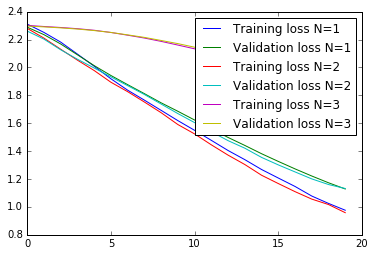

In [11]:
def main():
    # Load data
    train, test = get_mnist()
    
    # Initialize iterators
    train_iter = iterators.SerialIterator(train, batch_size=32, shuffle=True)
    val_iter = iterators.SerialIterator(test, batch_size=100, repeat=False, shuffle=False)

    # Define model NN1
    model = NN1(10, 10) ##10 neurons per layer
    optimizer = optimizers.SGD()
    optimizer.setup(model)

    training_losses, validation_losses = run(train_iter, val_iter, test, model, optimizer, 20) ##Max Epoch 20
    
    plt.plot(training_losses, label='Training loss N=1')
    plt.plot(validation_losses, label='Validation loss N=1')
    plt.legend()
    
    train_iter = iterators.SerialIterator(train, batch_size=32, shuffle=True)
    val_iter = iterators.SerialIterator(test, batch_size=100, repeat=False, shuffle=False)

    # Define model NN2 
    model = NN2(10, 10) ##10 neurons per layer
    optimizer = optimizers.SGD()
    optimizer.setup(model)

    training_losses, validation_losses = run(train_iter, val_iter, test, model, optimizer, 20) ##Max Epoch 20
    
    plt.plot(training_losses, label='Training loss N=2')
    plt.plot(validation_losses, label='Validation loss N=2')
    plt.legend()
    
    train_iter = iterators.SerialIterator(train, batch_size=32, shuffle=True)
    val_iter = iterators.SerialIterator(test, batch_size=100, repeat=False, shuffle=False)

    # Define model NN3
    model = NN3(10, 10) ##10 neurons per layer
    optimizer = optimizers.SGD()
    optimizer.setup(model)

    training_losses, validation_losses = run(train_iter, val_iter, test, model, optimizer, 20) ##Max Epoch 20
    
    plt.plot(training_losses, label='Training loss N=3')
    plt.plot(validation_losses, label='Validation loss N=3')
    plt.legend()

if __name__ == "__main__":
    main()

In [ ]:
CONLUCSIONS,WHATS BEST BLA BLA

## Question 2

A small convolutional network consisiting of one convolutional layer, a max pooling layer and a fully connected layer should be constructed and should be trained on the MNIST dataset.

First, a class is constructed which represents the network.

In [7]:
class SmallConv(Chain):
    def __init__(self, n_out):
        super(SmallConv, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, out_channels=5, ksize=5, stride=1, pad=0) # Convolutional layer
            self.fc1 = L.Linear(None, n_out) # Fully connected layer

    def __call__(self, x):
        h1 = self.conv1(x)
        h2 = F.max_pooling_2d(h1, ksize=5, stride=1, pad=0) # Max pooling layer
        y = self.fc1(h2)
        return y

In order to train the network, a training function is built. For every epoch, the function forwards a new mini-batch through the network, computes the loss and backwards the loss through the network such that variables can be updated. Furthermore, the network is evaluated by forwarding the test set of 100 images through it.

For both operations, the loss is printed and stored, such that it can be plotted after training. 

In [8]:
def run(train_iter, val_iter, test_data, model, optimizer, max_epoch):
    training_losses = []
    validation_losses = []
    
    mini_batch_losses = []

    while train_iter.epoch < max_epoch:
        # Get next mini-batch
        batch = train_iter.next()
        image_train, target_train = concat_examples(batch)

        # Prediction
        prediction_train = model(image_train)

        # Compute loss
        loss = F.softmax_cross_entropy(prediction_train, target_train)
        mini_batch_losses.append(loss.data)

        # Compute gradients
        model.cleargrads()
        loss.backward()

        # Update variables
        optimizer.update()

        # Check the validation accuracy of prediction after every epoch
        if train_iter.is_new_epoch:  # If this iteration is the final iteration of the current epoch

            # Save the training loss
            training_losses.append(np.mean(mini_batch_losses))
            mini_batch_losses = []

            val_losses = []
            val_accuracies = []
            while True:
                val_batch = val_iter.next()
                image_val, target_val = concat_examples(val_batch)

                # Forward the validation data
                prediction_val = model(image_val)

                # Calculate the loss
                loss_val = F.softmax_cross_entropy(prediction_val, target_val)
                val_losses.append(loss_val.data)

                # Calculate the accuracy
                accuracy = F.accuracy(prediction_val, target_val)
                val_accuracies.append(accuracy.data)

                if val_iter.is_new_epoch:
                    val_iter.epoch = 0
                    val_iter.current_position = 0
                    val_iter.is_new_epoch = False
                    val_iter._pushed_position = None

                    validation_losses.append(np.mean(val_losses))
                    break

    # Predict full test set
    image_test, target_test = concat_examples(test_data)
    # Forward test data
    prediction_test = model(image_test)
    # Calculate loss and accuracy
    loss_test = F.softmax_cross_entropy(prediction_test, target_test)
    accuracy_test = F.accuracy(prediction_test, target_test)

    print('test_loss: ' + str(loss_test.data) + ' test_accuracy: ' + str(accuracy_test.data))
    return training_losses, validation_losses

The full proces is run in the main function. First, the data is downloaded. Then, iterators are constructed which iterate over the data for every epoch. Then the model and the optimizer are constructed and last, the model is trained. 

test_loss: 0.33282366395 test_accuracy: 0.888999998569


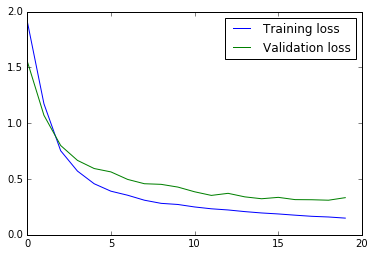

In [9]:
def main():
    # Load data
    train, test = get_mnist(n_dim=3)
    
    # Initialize iterators
    train_iter = iterators.SerialIterator(train, batch_size=32, shuffle=True)
    val_iter = iterators.SerialIterator(test, batch_size=100, repeat=False, shuffle=False)

    # Define model
    model = SmallConv(10)
    optimizer = optimizers.SGD()
    optimizer.setup(model)

    training_losses, validation_losses = run(train_iter, val_iter, test, model, optimizer, 20)
    
    plt.plot(training_losses, label='Training loss')
    plt.plot(validation_losses, label='Validation loss')
    plt.legend()

if __name__ == "__main__":
    main()

## Results
Todo, also depends on results from question 1

### Sources
Chainer: Example: Multi-layer Perceptron on MNIST
https://docs.chainer.org/en/stable/tutorial/basic.html#example-multi-layer-perceptron-on-mnist

Chainer: Write a training loop
https://docs.chainer.org/en/stable/tutorial/train_loop.html#write-a-training-loop

Convolutional Network for Visual Recognition Tasks
https://docs.chainer.org/en/stable/tutorial/convnet.html